#  Lightcurves, transits, and TESS! Oh My!


### Step 0: imports (Read the comment below please. You'll need to import a new package)

In [ ]:
# Run this once to install a python package for downloading lightcurves from the TESS mission (include the exclamation point)
# ! python -m pip install lightkurve --upgrade

In [ ]:
# these should be familar
import scipy
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# this package will allow us to make progress bars
from tqdm import tqdm

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.family'] = "serif"

# Step 1: loading data from the TESS mission


The function below uses the python package `lightkurve` to load data from the TESS mission. To search for exoplanets, TESS takes pictures of a patch of the sky once every 2 minutes. The function `load_TESS_data` takes in the name of a star and the size of image cutout we want to downdload (centered on the star).

In [ ]:
# this function downloades TESS lightcurves (I recommend we supply this function
# and have the student's use it as a black box)

def load_TESS_data(target, cutout_size=20, verbose=False, exptime=None):
    """
    Download TESS images for a given target.

    inputs:
        target: str, same of star (ex. TOI-700)
        cutout_size: int, size of the returned cutout
                     (in units of pixels)
        verbose: bool, controls whether to include printouts
        exptime: str, determines if we use short or long cadence mode
                 (if None, defaults to first observing semester)
    outputs:
        time: numpy 1D array
        flux: numpy 3D array (time x cutout_size x cutout_size)
    """

    import lightkurve as lk

    # find all available data
    search_result = lk.search_tesscut(target)
    if exptime == 'short':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.min()]
    elif exptime == 'long':
        search_result = search_result[search_result.exptime.value==search_result.exptime.value.max()]
    print(search_result)

    # select the first available observing sector
    if exptime:
        search_result = search_result[search_result.exptime == exptime]
    search_result = search_result[search_result.mission == search_result.mission[0]]

    # download it
    tpf = search_result.download_all(cutout_size=cutout_size)[0]

    # convert it to a numpy array format
    flux = np.array([
        tpf.flux[i].value for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0
    ])
    flux_err = np.array([
        tpf.flux_err[i].value for i in range(len(tpf.flux_err)) if tpf.flux[i].value.min()>0
    ])

    time = np.array([
        tpf.time.value[i] for i in range(len(tpf.flux)) if tpf.flux[i].value.min()>0
                    ])

    return time, flux, flux_err

**Exercise:** Run the code below to load all the TESS data for one small patch of the sky. We'll center our images on a single variable star.

In [ ]:
target = 'Gaia_DR2279382060625871360'
cutout_size = 20 # dimensions of the image in pixels x pixels
time, flux, flux_err = load_TESS_data(target,verbose=True,cutout_size=cutout_size)

SearchResult containing 4 data products.

 #     mission     year  author exptime        target_name         distance
                                   s                                arcsec 
--- -------------- ---- ------- ------- -------------------------- --------
  0 TESS Sector 19 2019 TESScut    1426 Gaia_DR2279382060625871360      0.0
  1 TESS Sector 59 2022 TESScut     158 Gaia_DR2279382060625871360      0.0
  2 TESS Sector 73 2023 TESScut     158 Gaia_DR2279382060625871360      0.0
  3 TESS Sector 86 2024 TESScut     158 Gaia_DR2279382060625871360      0.0


**Exercise:** Run the code below to plot the mean of the TESS cutouts.

In [ ]:
def plot_cutout(image, logscale = False, vrange = [1,99]):
    """
    Plot 2D image.

    inputs:
        image: 2D numpy array
        logscale: bool, if True plots np.log10(image)
        vrnge: list, sets range of colorbar
               (based on percentiles of 'image')
    """
    if logscale:
        image = np.log10(image)

    q = np.percentile(image, q = vrange)
    plt.imshow( image, vmin = q[0], vmax = q[1] )
    plt.show()

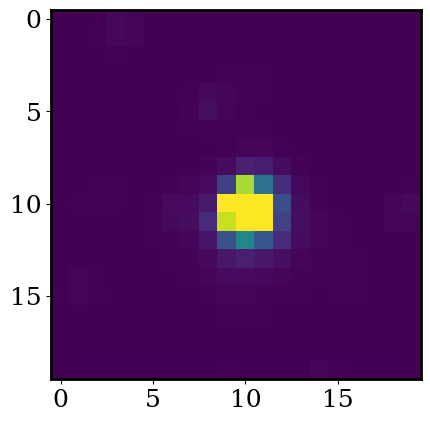

In [ ]:
# linear scale
plot_cutout(np.mean(flux,axis=0))

**Exercise:** Now use the same function to plot the mean TESS cutout with `logscale=True`. How many stars to do see in our cutout? How might this make searching for planets complicated?

In [ ]:
# answer here

# Step 2: Make a lightcurve

We want to measure the flux of the star in each image. We can then see how the star's flux changes with time. This allows us to study binary stars, exoplanets, and stellar pulsations (like Earthquakes but on stars). Let's start with the simplest option: taking the sum all pixels in image.

**Exercise:** Plot the total flux in each cutout as a function of time. Be sure to label your plot.

In [ ]:
# answer here

We can see this area of the sky is populated by more than one star (this is especially clear when we plot in log scale). This is very common occurance.

Because the image includes more than one star, simply taking the sum of all pixels in the image will not give us a very accurate number for the flux of the star we're intersted in. We also have to be careful about the background flux changing with time due to instrumental systematics.

A common method of overcoming these challenges is fitting the image with a two component model: background + star.

Since the star is being 'blurred' by the point spread function of TESS, we can reasonably model the star as a 2-dimensional Gaussian.

To keep things simple, let's assume a uniform background.

**Exercise:** Using the function below, plot a 2-d gaussian with the `plot_cutout` function. Set `mu=0, bkg=0, xmu=0, ymu=0`. Since we are plotting a 2-d gaussian, we need to create a grid of `x,y` values. Use the code below, which turns 1-d arrays of x and y into a 2-d grid of x and y.

In [ ]:
x = np.linspace(-5,5,50)
y = np.linspace(-5,5,50)
X, Y = np.meshgrid(x, y)

In [ ]:
def psf(x,y,sigma,scale,bkg,xmu=0,ymu=0,unravel=False):
    """
    Symmetric 2D point-spread function (PSF)

    inputs:
        x: np.ndarray, where to evaluate the PSF
        y: np.ndarray, where to evaluate the PSF
        sigma: float, width of the PDF
        scale: float, integrated area under the PSF
        bkg: float, background flux level
        xmu: float, center of PSF in x
        ymu: float, center of PSF in y
    outputs:
        PSF evalauted at x and y
    """
    exponent = (np.power(x-xmu,2) + np.power(y-ymu,2) ) / sigma**2

    mod = scale * np.exp(-exponent) / (2*np.pi*sigma**2) + bkg
    if unravel:
        return mod.ravel()
    else:
        return mod

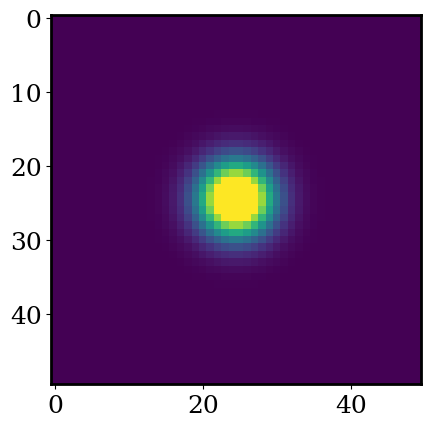

In [ ]:
Z = psf(X,Y,sigma=1,scale=1,bkg=0,xmu=0,ymu=0)

plot_cutout(Z,logscale=False)

We now have the ingredients for our model. To fit our model we need to quantify 'goodness of fit.'

**Exercise:** Run the code below to evaluate the residual between the first TESS cutout and our model.

In [ ]:
def residual(theta, x, y, z, z_err):
    sigma, scale, bkg, xmu, ymu = theta

    model = psf(x,y,sigma=sigma,scale=scale,bkg=bkg,xmu=xmu,ymu=ymu)

    chi = np.power(model - z,2)/z_err**2

    return np.sum(chi)

In [ ]:
# where to evaluate our PSF
x = np.arange(flux.shape[1])
y = np.arange(flux.shape[2])
X,Y = np.meshgrid(x,y)

In [ ]:
# lets evaluate the model for a set of parameters
theta = [
    1,  # sigma
    200,  # scale
    0,  # bkg
    cutout_size/2, # xmu
    cutout_size/2, # ymu
]

residual(theta, X, Y, flux[0]/np.mean(flux), flux_err[0]/np.mean(flux))

np.float64(415386221.45279515)

Using our residual function, we can now ask: what parameters (like stellar flux) best fit the image? To give some intuition, let's start with a simple grid search.

**Exercise:** For `0 < scale < 1000` calculate `residual`. Then plot `scale` vs. `residual`. Set `sigma=1, bkg =1, xmu=cutout_size/2, ymu=cutout_size/2`.

In [ ]:
# answer here

**Exercise:** Based on the above plot, what `scale` gives the best fit?

answer here

Above, we found the best fit flux (what we call `scale` in our function) for a single TESS cutout. To make a lightcurve we need to repeat that process for each image.

**Exercise:** For each cutout, find the `scale` that minimizes `residual` (search for `0 < scale < 1000`). Like above, set `sigma=1, bkg =1, xmu=cutout_size/2, ymu=cutout_size/2`. Plot the best fit `scale` vs. time to make our lightcurve. Plot our simple "summed" lightcurve for comparison.

In [ ]:
# answer here

**Exercise:** What are the differences between our "grid-search" and "sum" light curves? What might be the reason(s)?

answer here

We've made a lightcurve! And we can clearly see by eye that the star is variable (it's flux is changing with time). However, our approach is still a little too simple. While we are optimizing the `scale` parameter, we've left all the other model parameters fixed.

As we discussed in class, we can optimize all the parameters of model using `scipy.optimize.minimize`. This is much much faster than trying a grid search across all the parameters at once.

**Exercise:** Using `scipy.optimize.minimize` find the best-fit `scale` for each TESS cutout. Plot the resulting lightcurve alongside out "grid-search" and "sum" lightcurves.

You'll want to try searching in these ranges: (.1,5) for `sigma`, (0,1000) for `scale`, (0,10) for `bkg`, (5,15) for `xmu` and `ymu`.

In [ ]:
# answer here